In [1]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load datasets
transactions_df = pd.read_csv('Transactions.csv')
customers_df = pd.read_csv('Customers.csv')

In [3]:
# Convert date columns to datetime
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])

In [4]:
# Aggregate transaction data
customer_transactions = transactions_df.groupby('CustomerID').agg(
    TotalSpent=('TotalValue', 'sum'),
    TotalQuantity=('Quantity', 'sum'),
    TransactionCount=('TransactionID', 'count'),
    FirstTransaction=('TransactionDate', 'min'),
    LastTransaction=('TransactionDate', 'max')
).reset_index()


In [5]:
# Merge with customer profile information
customer_data = pd.merge(customers_df, customer_transactions, on='CustomerID', how='inner')

In [6]:
# Calculate additional features
customer_data['CustomerLoyalty'] = (datetime.now() - customer_data['SignupDate']).dt.days
customer_data['Recency'] = (datetime.now() - customer_data['LastTransaction']).dt.days

In [7]:
# Drop unnecessary columns for clustering
clustering_data = customer_data.drop(columns=['CustomerID', 'CustomerName', 'Region',
                                              'SignupDate', 'FirstTransaction', 'LastTransaction'])

In [8]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)


In [9]:
# Perform clustering with different numbers of clusters
db_indices = []
silhouette_scores = []
clusters_range = range(2, 11)

for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)
    db_index = davies_bouldin_score(scaled_data, cluster_labels)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    db_indices.append(db_index)
    silhouette_scores.append(silhouette_avg)

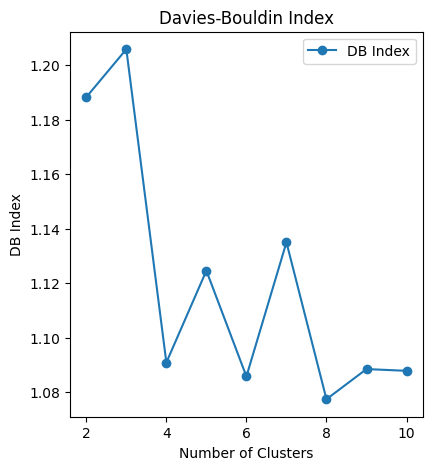

In [11]:
# Plot DB Index and Silhouette Score
plt.figure(figsize=(10, 5))
# DB Index plot
plt.subplot(1, 2, 1)
plt.plot(clusters_range, db_indices, marker='o', label='DB Index')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.legend()



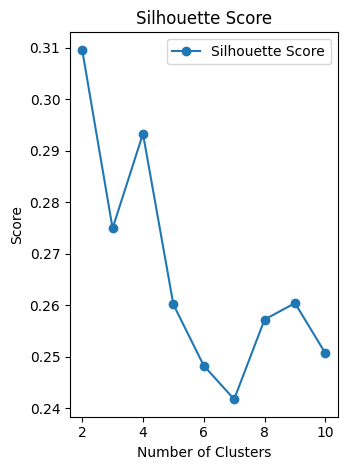

In [12]:
# Silhouette Score plot
plt.subplot(1, 2, 2)
plt.plot(clusters_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# Choose the optimal number of clusters (e.g., based on lowest DB Index)
optimal_clusters = clusters_range[db_indices.index(min(db_indices))]
print(f"Optimal number of clusters: {optimal_clusters}")

Optimal number of clusters: 8


In [14]:
# Final clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

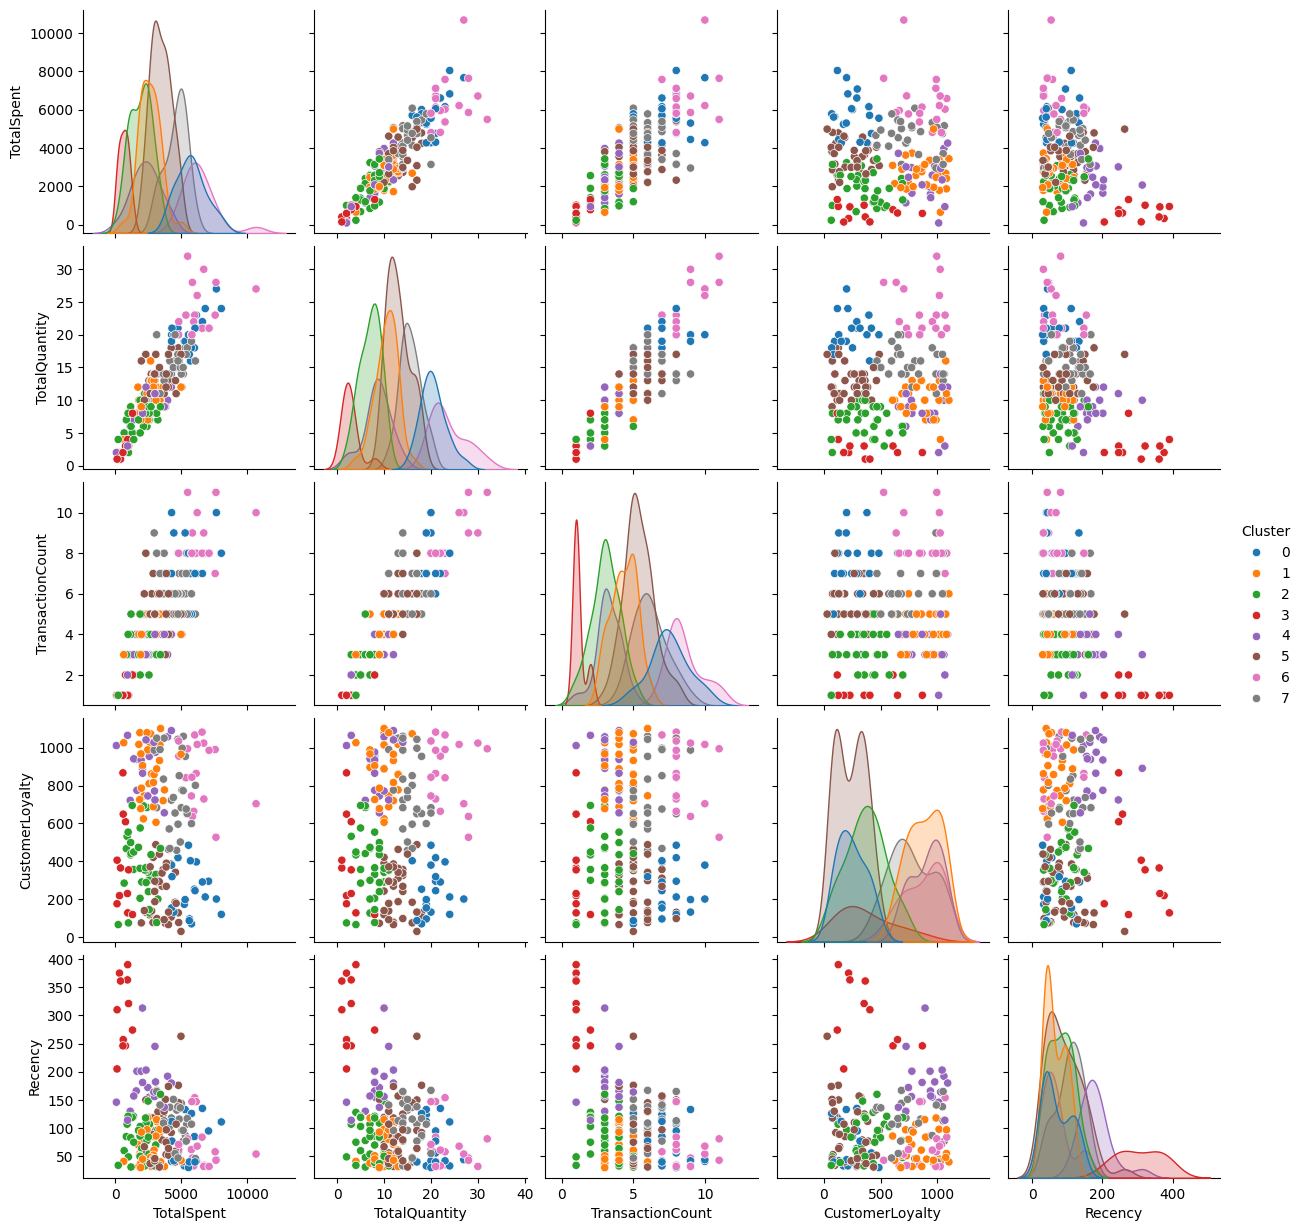

In [15]:
# Visualize clusters
sns.pairplot(customer_data, hue='Cluster', diag_kind='kde', palette='tab10')
plt.show()

In [16]:
# Output DB Index and relevant metrics
db_index_optimal = davies_bouldin_score(scaled_data, customer_data['Cluster'])
print(f"Davies-Bouldin Index for optimal clustering: {db_index_optimal}")

Davies-Bouldin Index for optimal clustering: 1.0774694382171526
